In [1]:
import os

In [2]:

import tensorflow_hub as hub

import spacy
# Plotting tools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# For modeling
import pathlib
import tensorflow as tf



In [79]:
import sys
landscape_path = "../../patents-public-data/models/landscaping"
sys.path.append(landscape_path)
raw_data_path = "../data/raw"
pickle_path = '../pickles'

### Read in revenue segmentation data

In [158]:
df = pd.read_excel(os.path.join(raw_data_path,'revere tree 2019_v1.xlsx'))
df['N_D'] = '['+df.NAME+']' + df.DESCRIPTION
df_full = pd.read_excel(os.path.join(raw_data_path,'revere tree 2019.xlsx'))
df_full['N_D'] = '['+df_full.NAME+']'  + df_full.DESCRIPTION

In [159]:
df_unlabeled = df_full[~df_full['DESCRIPTION'].isin(df.DESCRIPTION.tolist())]


# => Preprocess  [  <span style="color:blue">'clean' text</span>  ]



# => Word/ Sentence Embedding  [  <span style="color:red">512-D vector</span>  ]

#           => T-SNE  [  <span style="color:red">2-D vector</span>  ]
#                     => Visualize Embedding


<br>


### Text Prepocessing
+ `Tokenization`
    + Chop a text sequence into pieces
    
+ `Remove unnecessay part of speech`
    + Punctuation
    + 'and' , 'or'
    + 'is', 'were'
    + '/'
    + 'that', 'which'
+ `Lemmentization`
    + Find the root of each word
+ `Put lemma together`

    
#### Example
+ `Input`:Wholesalers which provide electricity generated by alternative, including renewable, technologies in Canada.
<br> 
+ `Output`:wholesaler provide electricity generate alternative include renewable technology Canada

In [8]:

import en_core_web_md
sp = en_core_web_md.load()
sentence3 = sp(u'Wholesalers which provide electricity generated by alternative, including renewable, technologies in Canada.')
sentence3
for token in sentence3:
    print(token.string,'--->',token.lemma_,'\t',token.pos_)

Wholesalers  ---> wholesaler 	 NOUN
which  ---> which 	 DET
provide  ---> provide 	 VERB
electricity  ---> electricity 	 NOUN
generated  ---> generate 	 VERB
by  ---> by 	 ADP
alternative ---> alternative 	 NOUN
,  ---> , 	 PUNCT
including  ---> include 	 VERB
renewable ---> renewable 	 ADJ
,  ---> , 	 PUNCT
technologies  ---> technology 	 NOUN
in  ---> in 	 ADP
Canada ---> Canada 	 PROPN
. ---> . 	 PUNCT


In [9]:
def lemmentize_sent(sent):
    sent = sp(sent)
    lemms = [token.lemma_ for token in sent \
             if token.pos_ not in ['PUNCT','CCONJ','SYS','ADP','AUX','DET']] 
                                                            # ADP: 'at','of'
                                                            # SYS: '/'
                                                            # DET: 'that' 
                                                            # AUX:' is' 
    return ' '.join(lemms)


In [201]:
df['name_lemma'] = df['NAME'].apply(lemmentize_sent)
df['description_lemma'] = df['DESCRIPTION'].apply(lemmentize_sent)

In [202]:
%%time
df_unlabeled.loc[:,'description_lemma'] = df_unlabeled['DESCRIPTION'].apply(lemmentize_sent)

CPU times: user 56.1 s, sys: 891 ms, total: 56.9 s
Wall time: 57.5 s


/Users/liuweitingting/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/liuweitingting/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


##  Embedding 
### + Sentence Level:    Universal Sentence Encoder
### +  Word Level:  Word2Vec/ FastText/ Glove -> Aggregate


### Load the [Universal Sentence Encoder](https://tfhub.dev/google/collections/universal-sentence-encoder/1)'s TF Hub module
* We use the latest two versions and compare their emedding results

In [292]:
import os
import tensorflow as tf
import tensorflow_hub as hub

os.environ['TFHUB_CACHE_DIR'] = '/Users/liuweitingting/opt/anaconda3/tf_cache'

In [293]:
%%time
import tensorflow_hub as hub
hub_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
# embed = hub.KerasLayer(hub_url)
embed5 = hub.load(hub_url )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


CPU times: user 20 s, sys: 2.38 s, total: 22.4 s
Wall time: 23.4 s


In [294]:
%%time
embed4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

CPU times: user 2.65 s, sys: 82.7 ms, total: 2.73 s
Wall time: 2.76 s


In [90]:
import pickle
def to_pickle(obj,folder,file_name):
    pickle_out = open(os.path.join(pickle_path,folder,file_name),'wb')  # writing bytes
    pickle.dump(obj,pickle_out)
    pickle_out.close()

In [91]:
def from_pickle(folder,file_name):
    pickle_in = open(os.path.join(pickle_path,folder,file_name),'rb')
    return pickle.load(pickle_in)

In [94]:
%%time
USE5_name = embed5(df['name_lemma'].tolist()).numpy()  # from_pickle('embedded_vecs','USE_5_name.pickle')
USE5_desc= embed5(df['description_lemma'].tolist()).numpy() # from_pickle('embedded_vecs','USE_5_desc.pickle')

CPU times: user 12.2 s, sys: 2.62 s, total: 14.8 s
Wall time: 6.87 s


In [96]:
%%time
USE4_name = embed4(df['name_lemma'].tolist()).numpy()   # from_pickle('embedded_vecs','USE_4_name.pickle')
USE4_desc= embed4(df['description_lemma'].tolist()).numpy()  # from_pickle('embedded_vecs','USE_4_desc.pickle')

CPU times: user 435 ms, sys: 63.6 ms, total: 499 ms
Wall time: 415 ms


In [326]:
def plot_similarity(x_labels,y_labels, features, rotation,**args):
    corr = np.inner(features, features)
    sns.set(font_scale=0.8)
    plt.figure(figsize=(14,12))
    g = sns.heatmap(
      corr,
             
      xticklabels=x_labels,
      yticklabels=y_labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    if 'title' in args:
        g.set_title(args['title'])
    else:
        g.set_title("Semantic Textual Similarity")
    g.set_xticklabels(x_labels, rotation=rotation)
    

def run_and_plot(x_labels,y_labels,messages_,model):
    message_embeddings_ = model(messages_)
#     print(type(message_embeddings_.eval))
#     print(dir(message_embeddings_))
    plot_similarity(x_labels,y_labels,message_embeddings_, 90)

### Embedding Comparison
+ In the folowing two graphs, we plot the heatmap of similarity score among all the embedded revenue description using USE V4 and USE V5
    + y labels are revenue names, and x labels are the corresponding theme
    + We order the the data by theme and name
+ An idea embedding would have high similarity score among texts from the same category(Theme)
    + We would like to see 3 darker squares along the diagnal, each of the length equal to the number of names in the theme
    + Or we also like to see smaller darker swaures along the diagnal formed by renues of the same name
+ From the following graphs, v4 and v5 have comparably good results.i.e. They are good at caputuring the semantic textual similarity of description

<IPython.core.display.Javascript object>


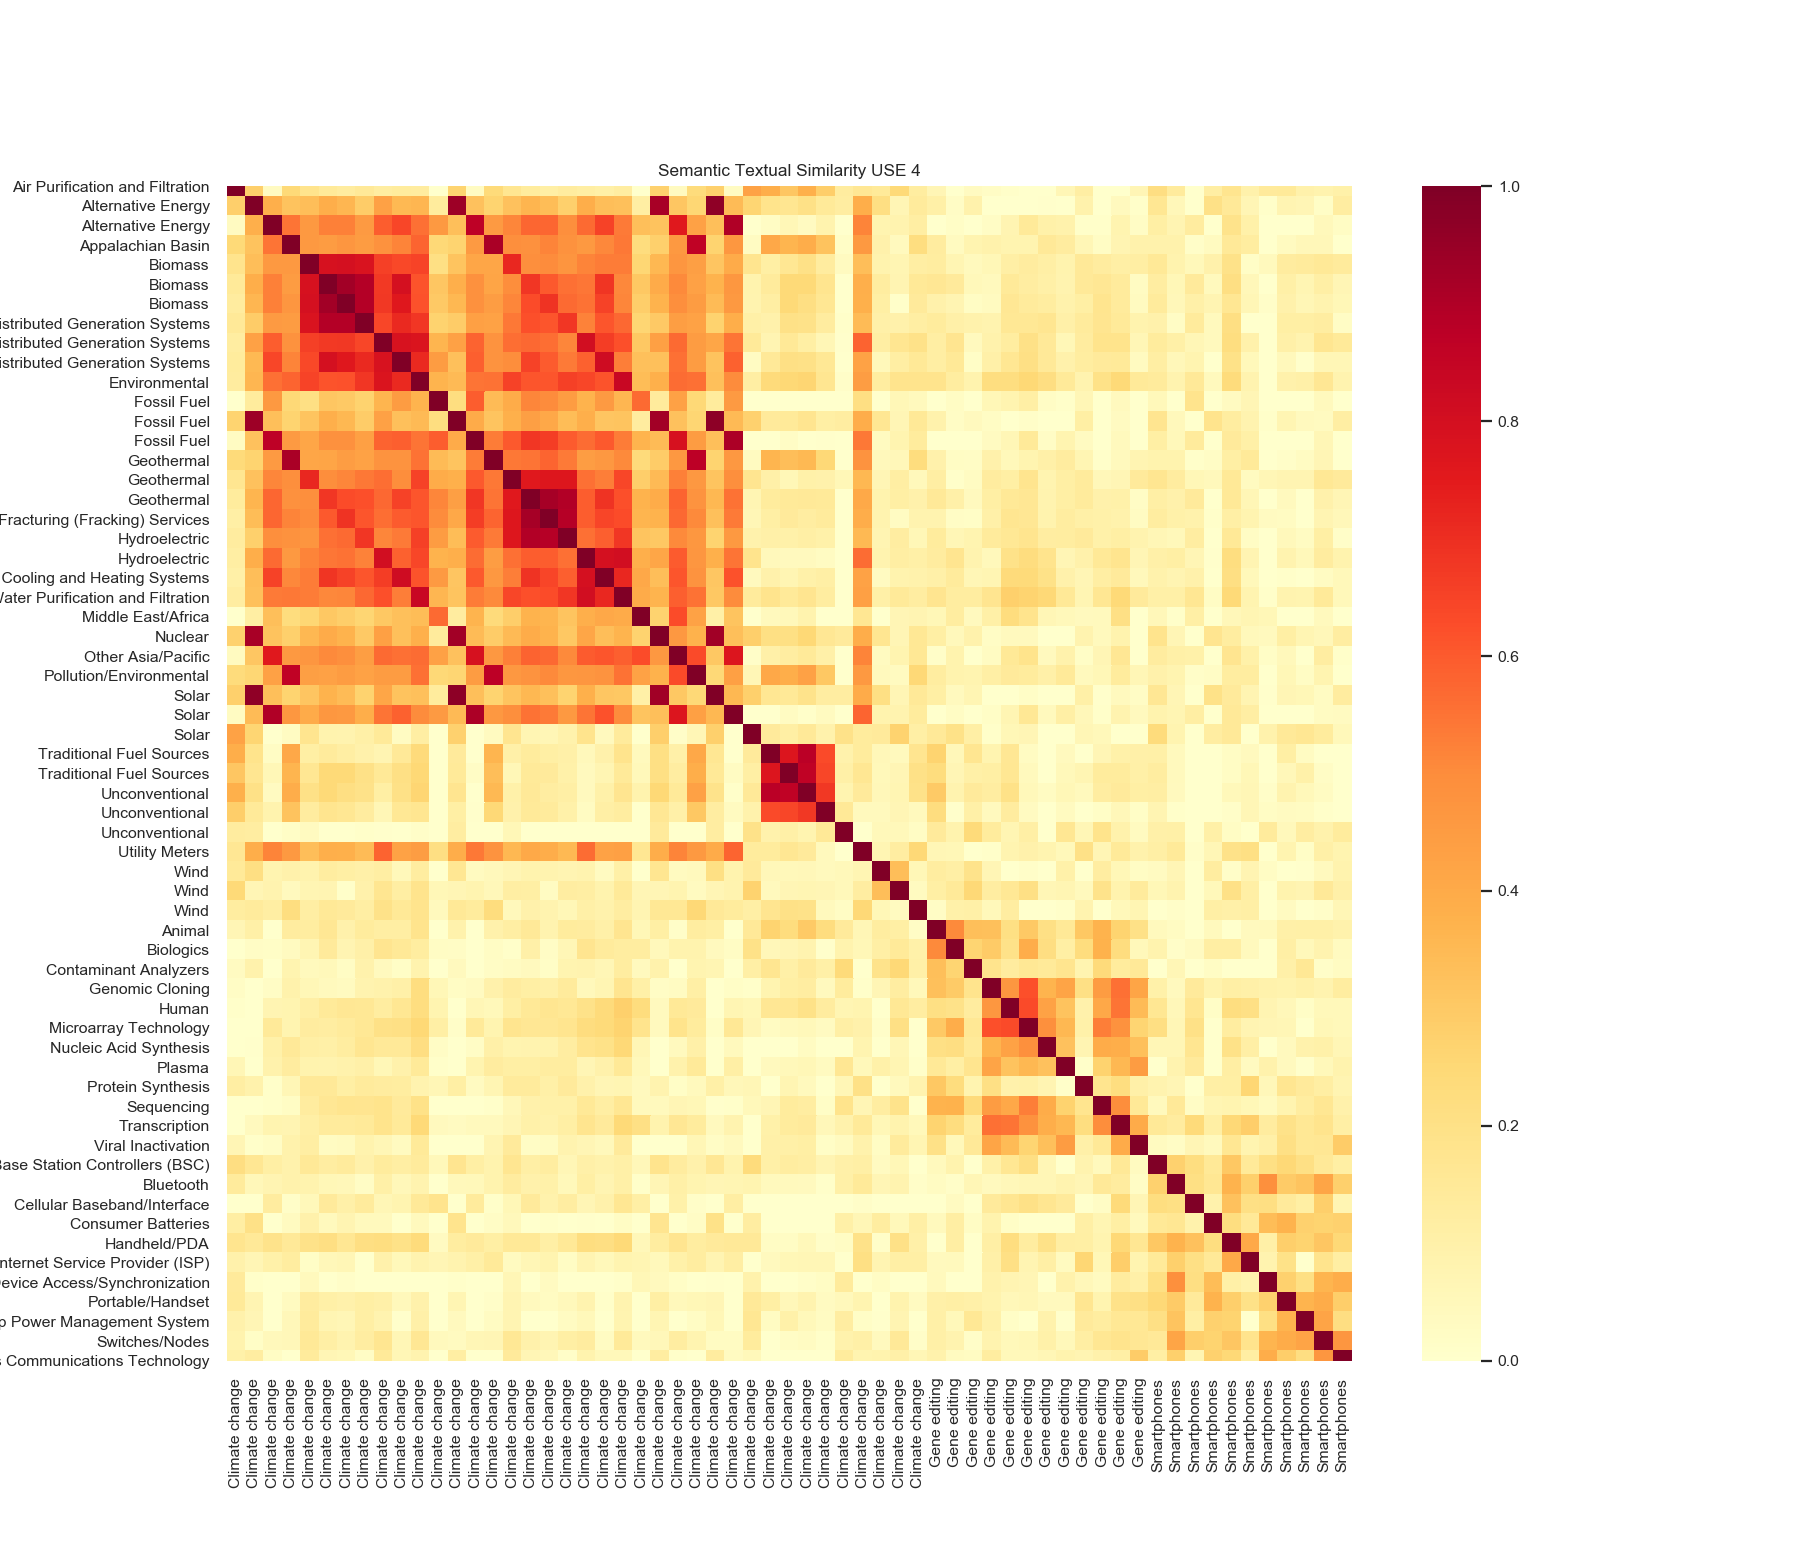

In [327]:
%matplotlib notebook
df = df.sort_values(['Theme','NAME'])
plot_similarity(df.Theme.iloc[::3],df.NAME.iloc[::3], USE4_desc[::3], rotation=90,title='Semantic Textual Similarity USE 4')


<IPython.core.display.Javascript object>


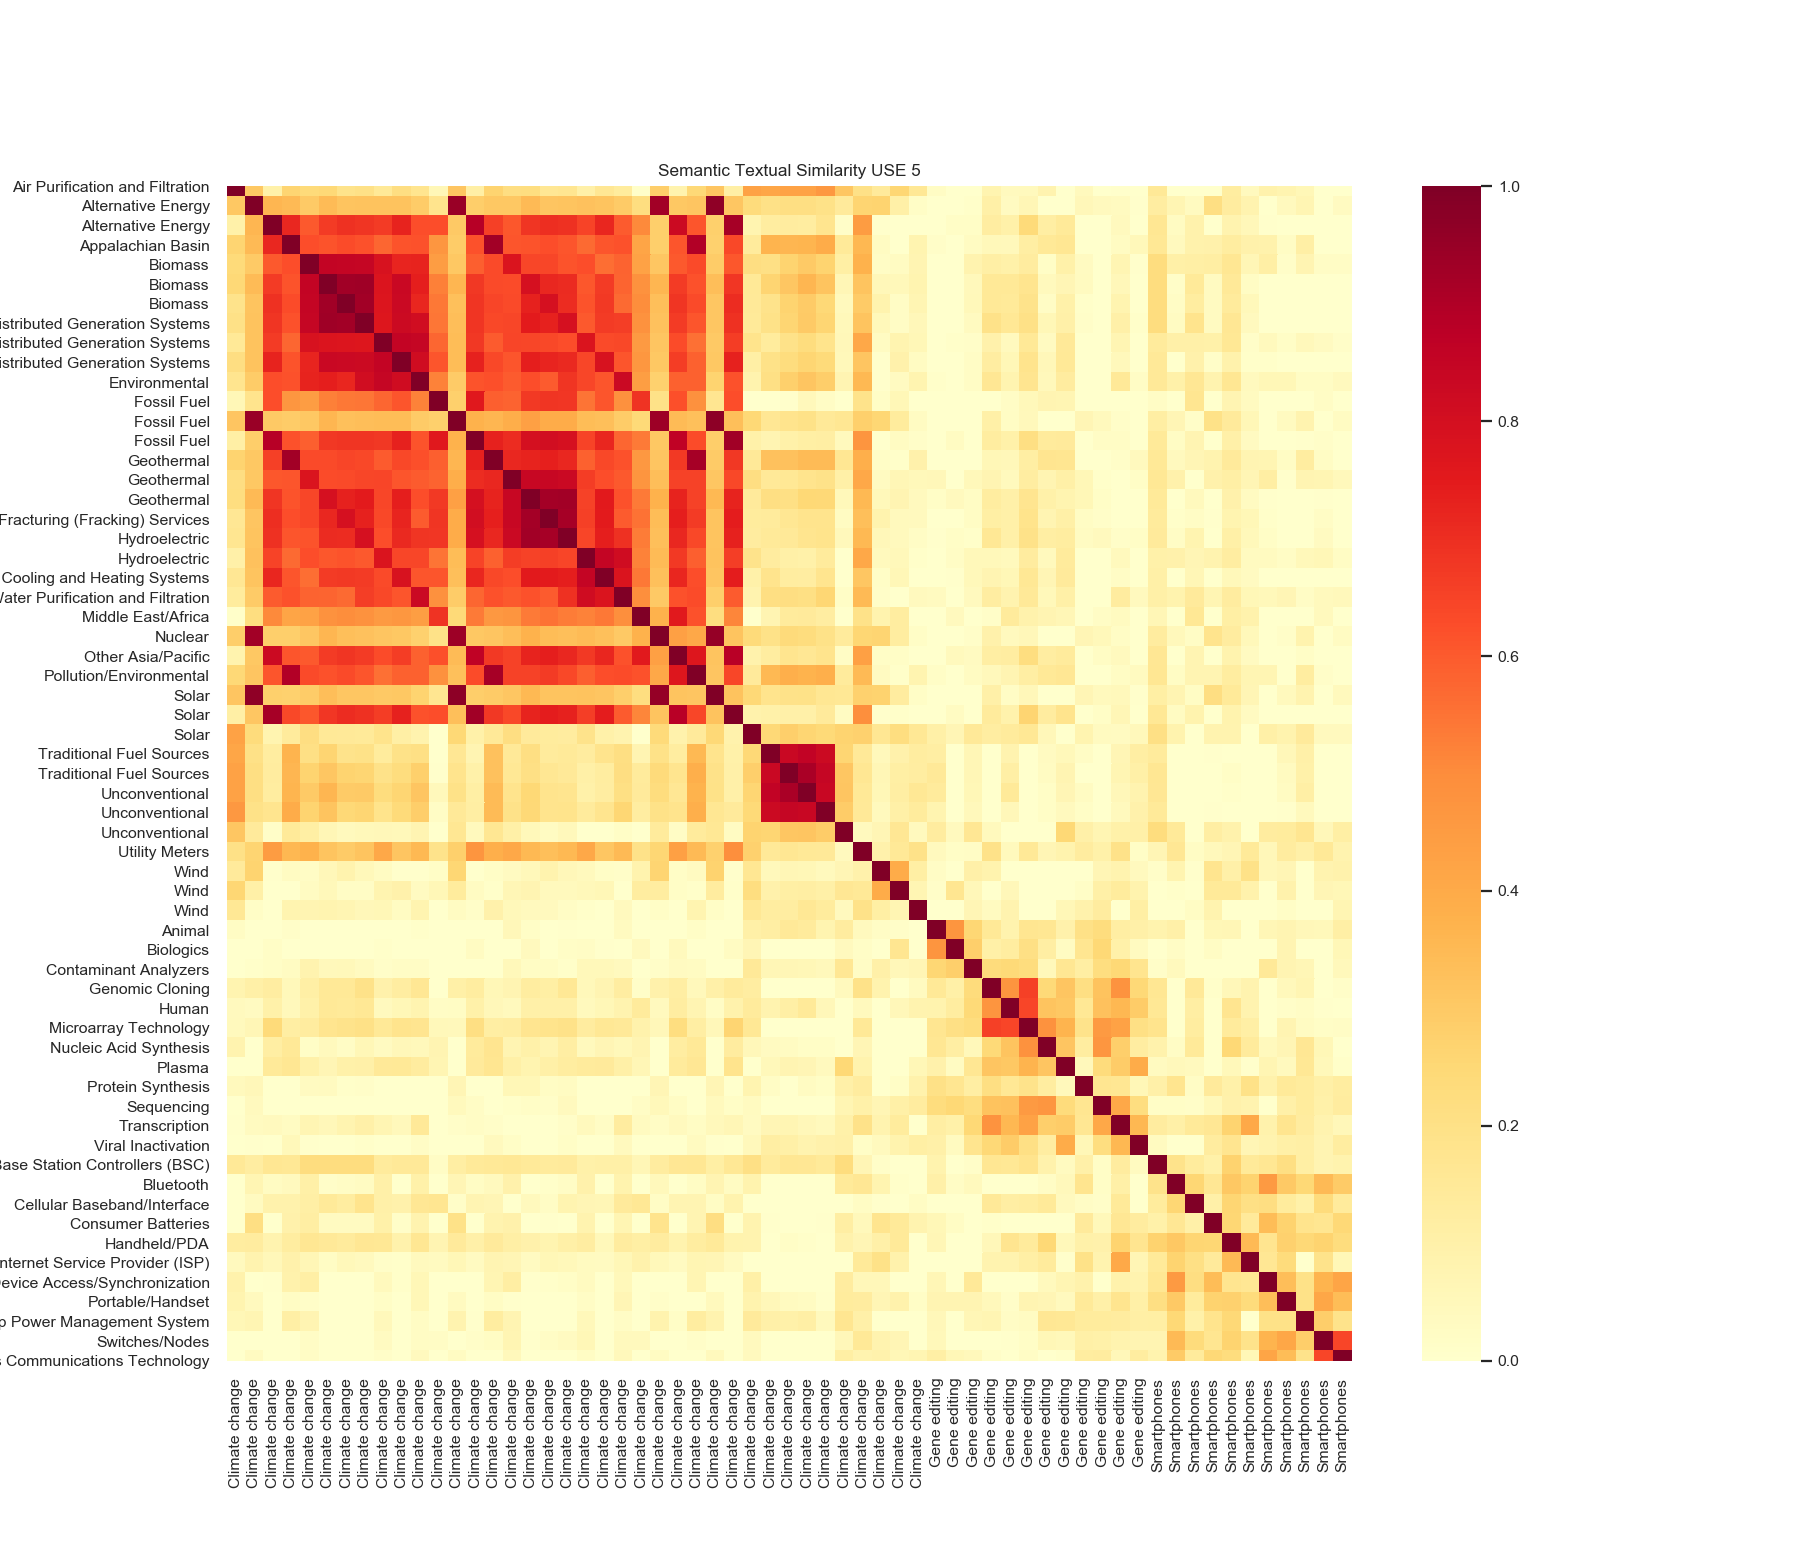

In [328]:


# run_and_plot(df.Theme.iloc[::],df.NAME.iloc[::],df.description_lemma.iloc[::],embed4)
plot_similarity(df.Theme.iloc[::3],df.NAME.iloc[::3], USE5_desc[::3], rotation=90,title='Semantic Textual Similarity USE 5')


In [103]:
%%time

USE5_desc_test= embed5(df_unlabeled['description_lemma'].tolist()).numpy() # from_pickle(embedded_vecs','USE5_desc_test.pickle')


CPU times: user 4min 16s, sys: 1min, total: 5min 16s
Wall time: 50 s


In [104]:
USE4_desc_test= embed4(df_unlabeled['description_lemma'].tolist()).numpy() # from_pickle(embedded_vecs','USE4_desc_test.pickle')


In [16]:


%matplotlib notebook # Need the interactive Tools for Matplotlib
import numpy as np
from sklearn.manifold import TSNE

In [17]:
def displayTSNE2(df,label_col, vec,title='TSNE(2D)',**args):
    
    tsne = TSNE(n_components=2, random_state=0)
    vec2d = tsne.fit_transform(vec.tolist())
    
    plt.figure(figsize=(14,10))
    plt.title(title,fontsize=20)
    sns.set(style="white")
    ax = sns.scatterplot(x=vec2d[:, 0], y=vec2d[:, 1], hue=df[label_col],sizes=500
                         ,
                     palette="Set1")
    if 'annot_col' in args:
        for idx in range(len(df)):
            plt.annotate(df.iloc[idx][args['annot_col']], (vec2d[idx, 0], vec2d[idx, 1]), alpha=0.7)  
    
    plt.legend(fontsize=15)
    plt.show()

### Embedding visualization
+ To get a sense of how the embedded represent the text data, we could after applying t-SNE dimension reduction
    + `t-SNE` is a nonlinear dimensionality reduction technique
    + Unlike linear techniques,such as PCA, it tends to preserve the clustering pattern in higher dimension
+ We first plot the embedded revenue name
    + We could see some red spots form a circle. When we take a closer look, we can see that they are embedded from the exact same texts. The reason for this phenomenon is not due to they have different high-dimensional embedding vectors, rather they are reduced to slightly different 2-D vectors due to the randomness in the t-SNE model
+ We then plot the embedded revenue descriptions
    + No matter V4,V5, the reduced vectors tend to form a cluster within each theme, with a few exceptions
    + We could take a closer look at the outliers,as a way of correcting the human labeling 'mistakes
    + Outliers in 2-D don't necessarily mean our embedding is not reliable. Remember that, we lose many infomation during the t-SNE process. For this reason, the very small number of outliers show the good performance of the embedding models

<IPython.core.display.Javascript object>


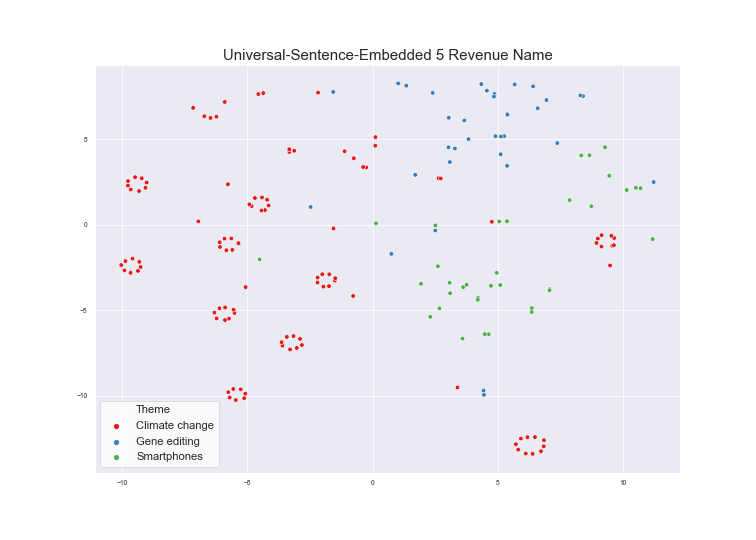

In [329]:
displayTSNE2(df.iloc[::], 'Theme',USE5_name[::],'Universal-Sentence-Embedded 5 Revenue Name')

<IPython.core.display.Javascript object>


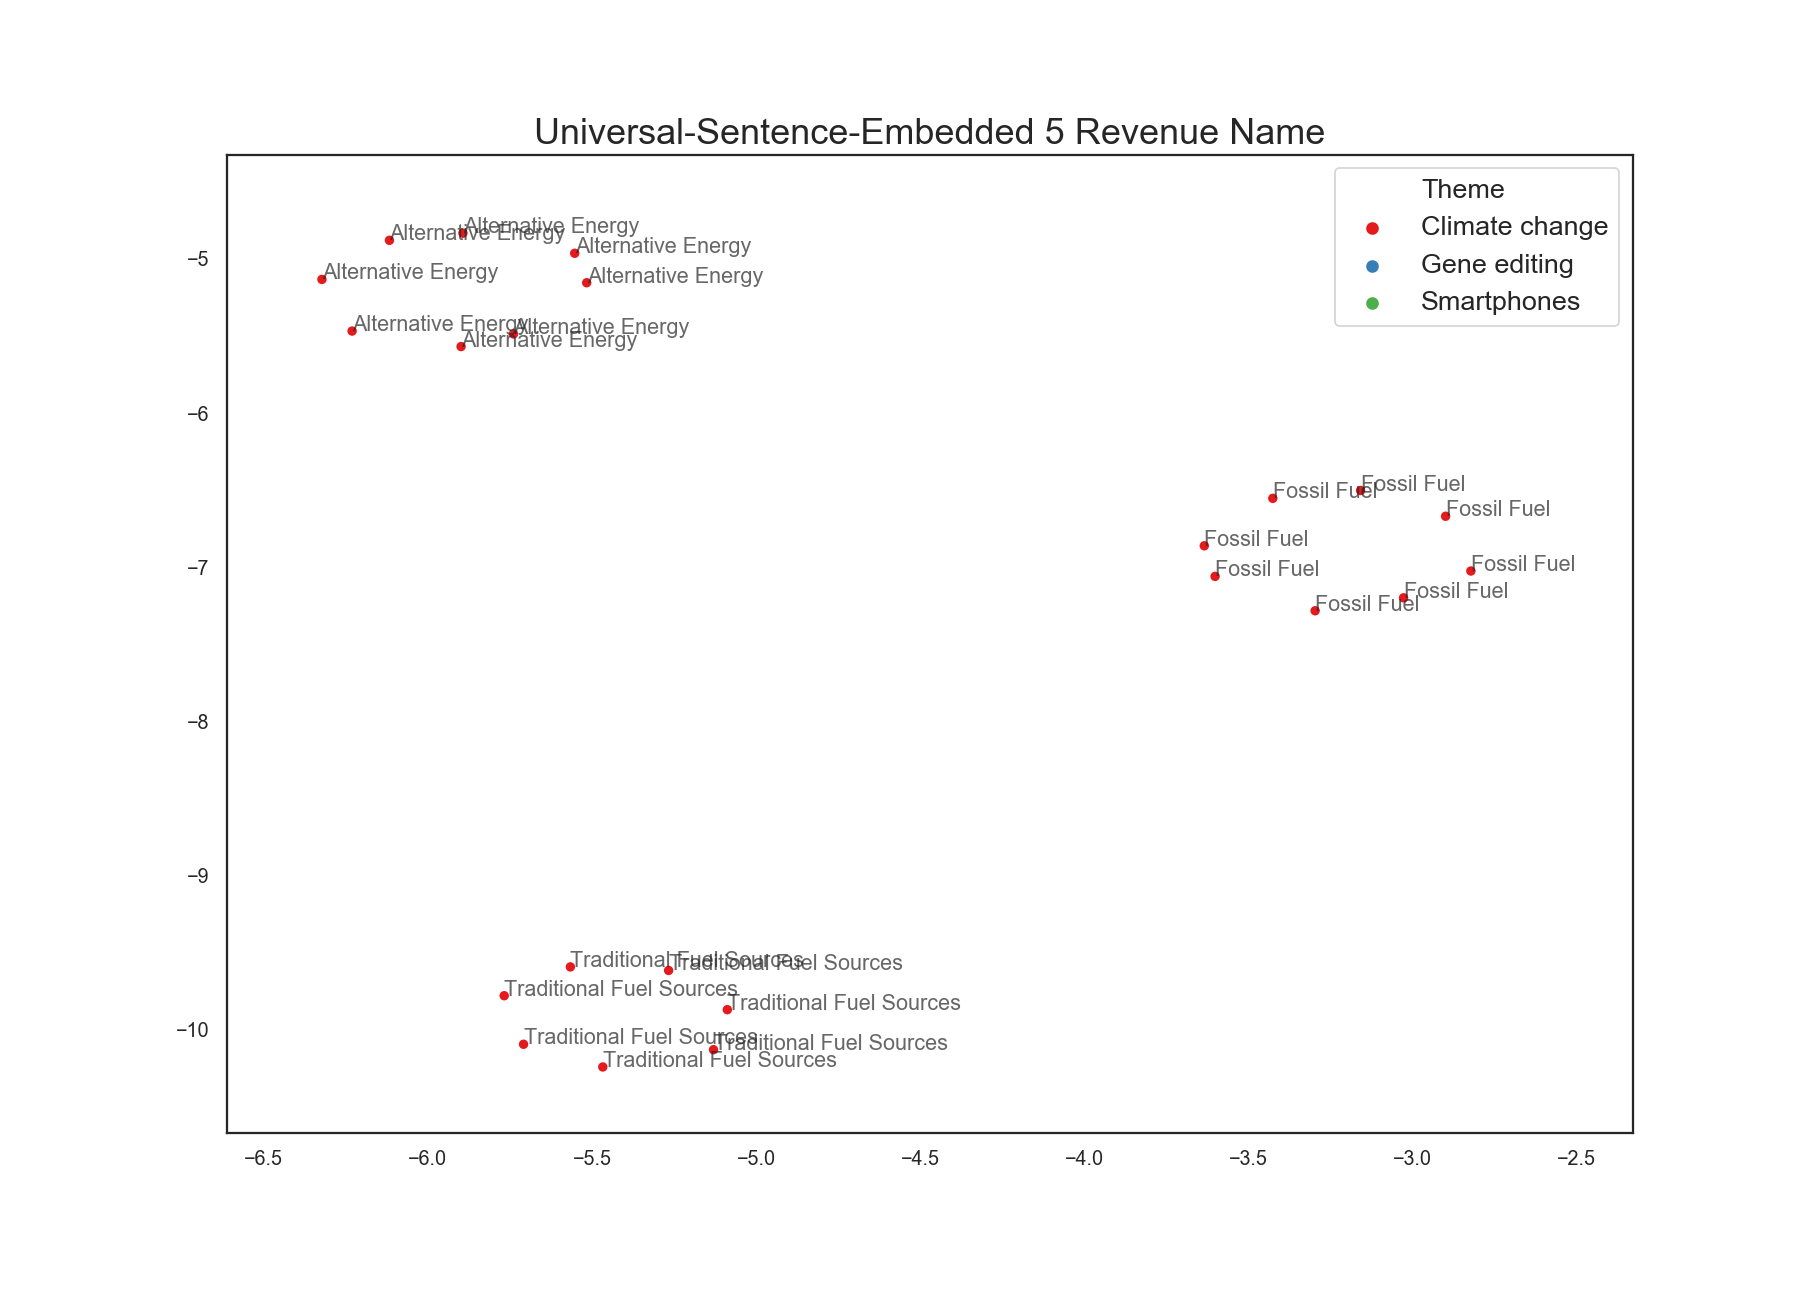

In [119]:
displayTSNE2(df.iloc[::], 'Theme',USE5_name[::],'Universal-Sentence-Embedded 5 Revenue Name',annot_col = 'NAME')

<IPython.core.display.Javascript object>


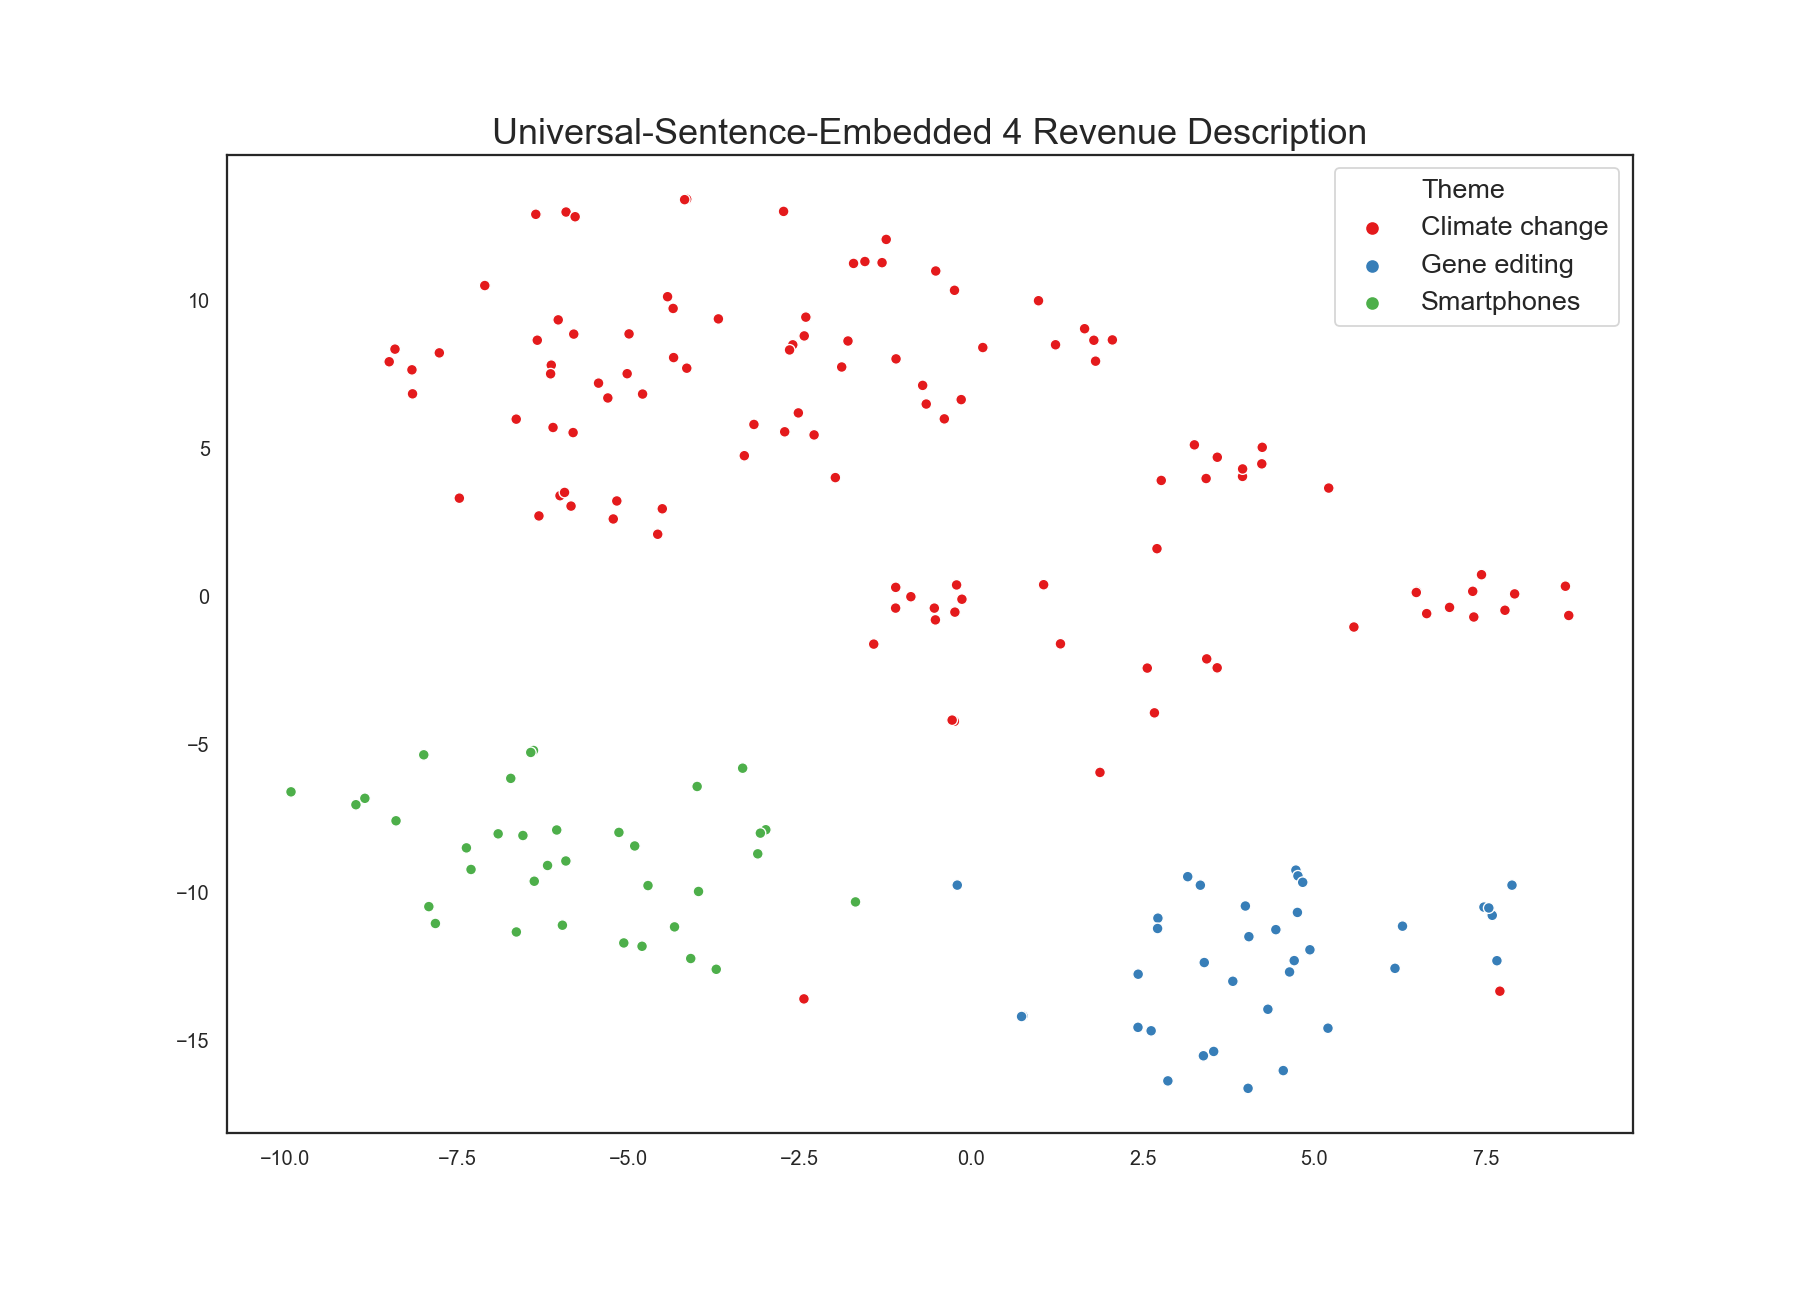

In [121]:
displayTSNE2(df.iloc[::], 'Theme',USE4_desc[::],'Universal-Sentence-Embedded 4 Revenue Description')

<IPython.core.display.Javascript object>


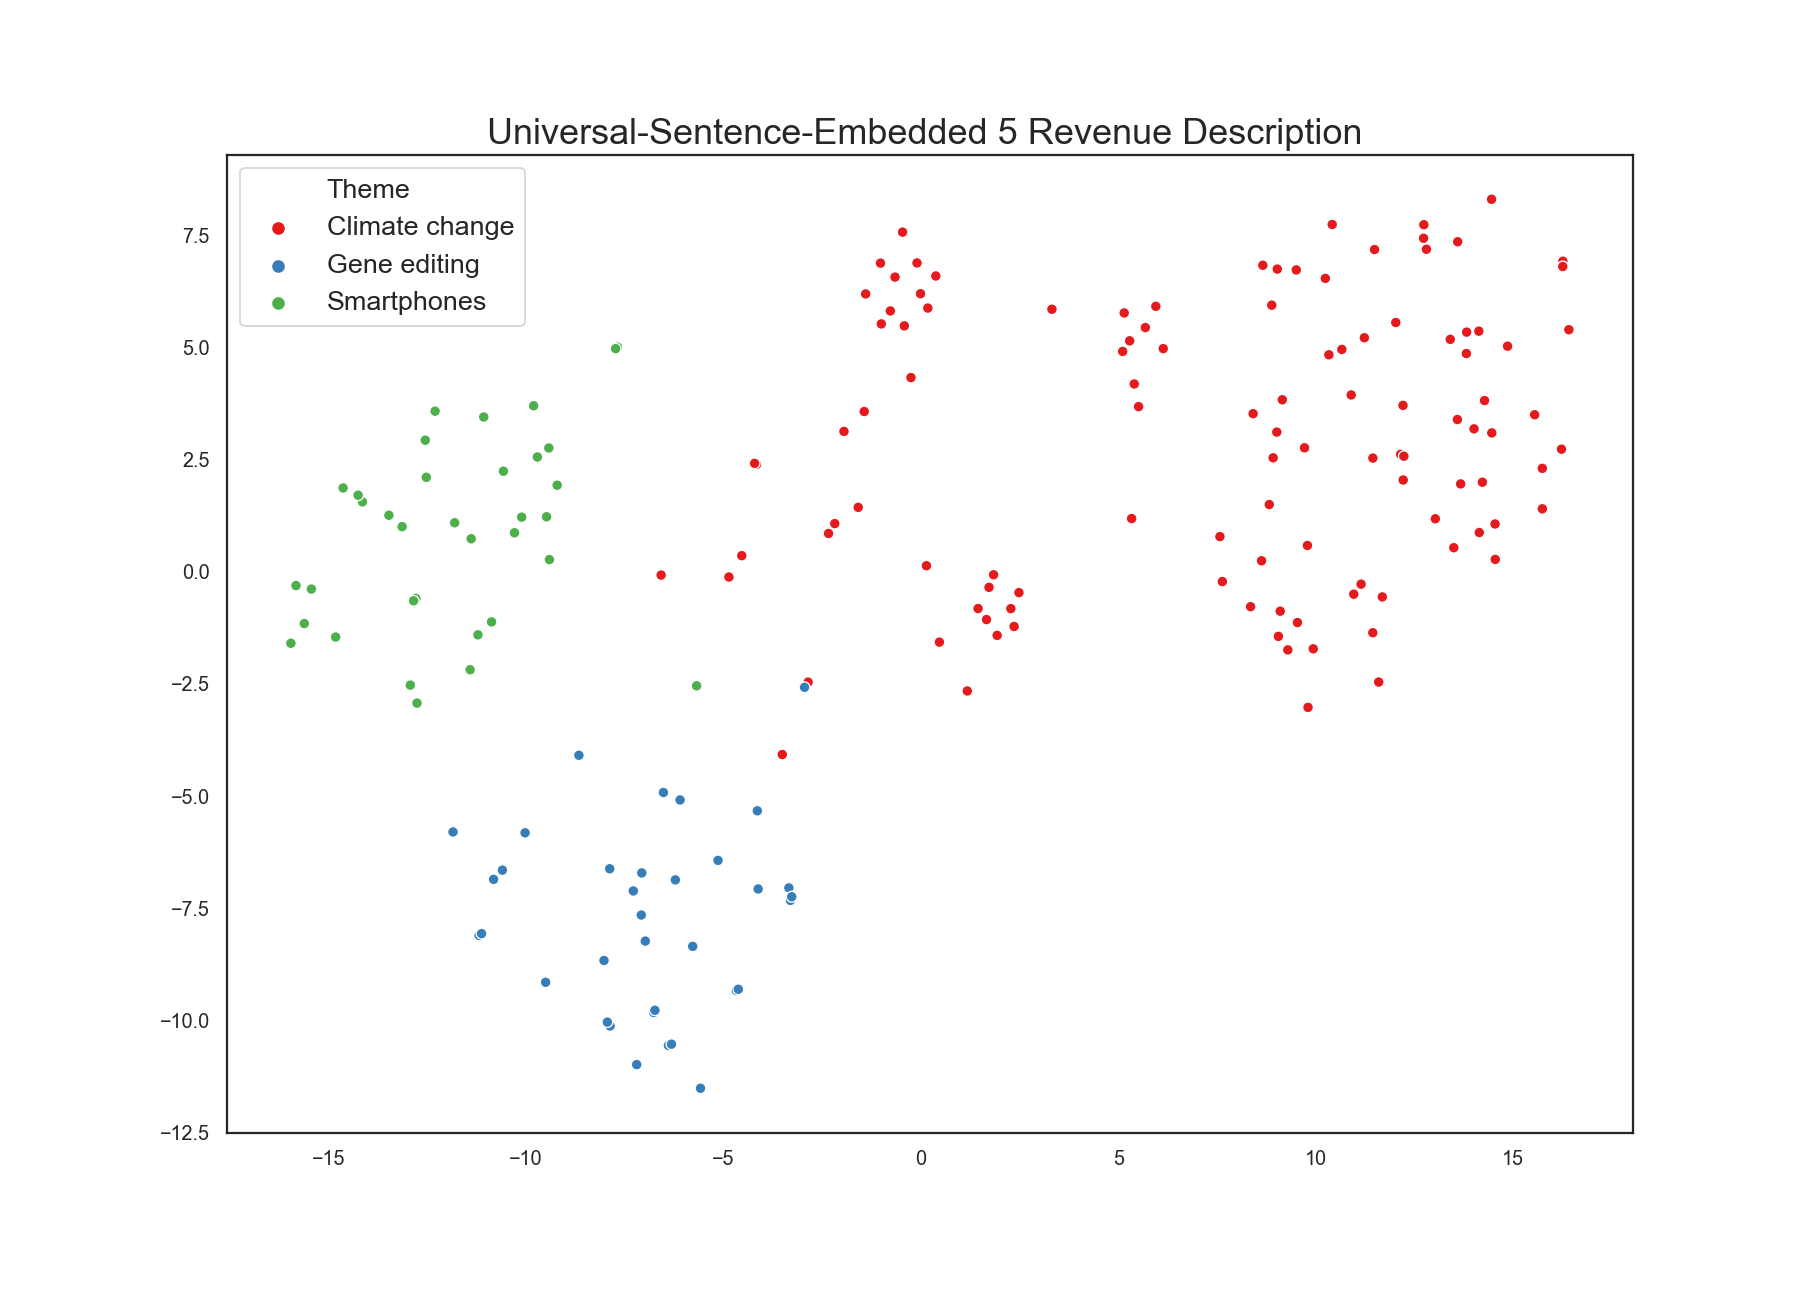

In [122]:
displayTSNE2(df.iloc[::], 'Theme',USE5_desc[::],'Universal-Sentence-Embedded 5 Revenue Description ')

<IPython.core.display.Javascript object>


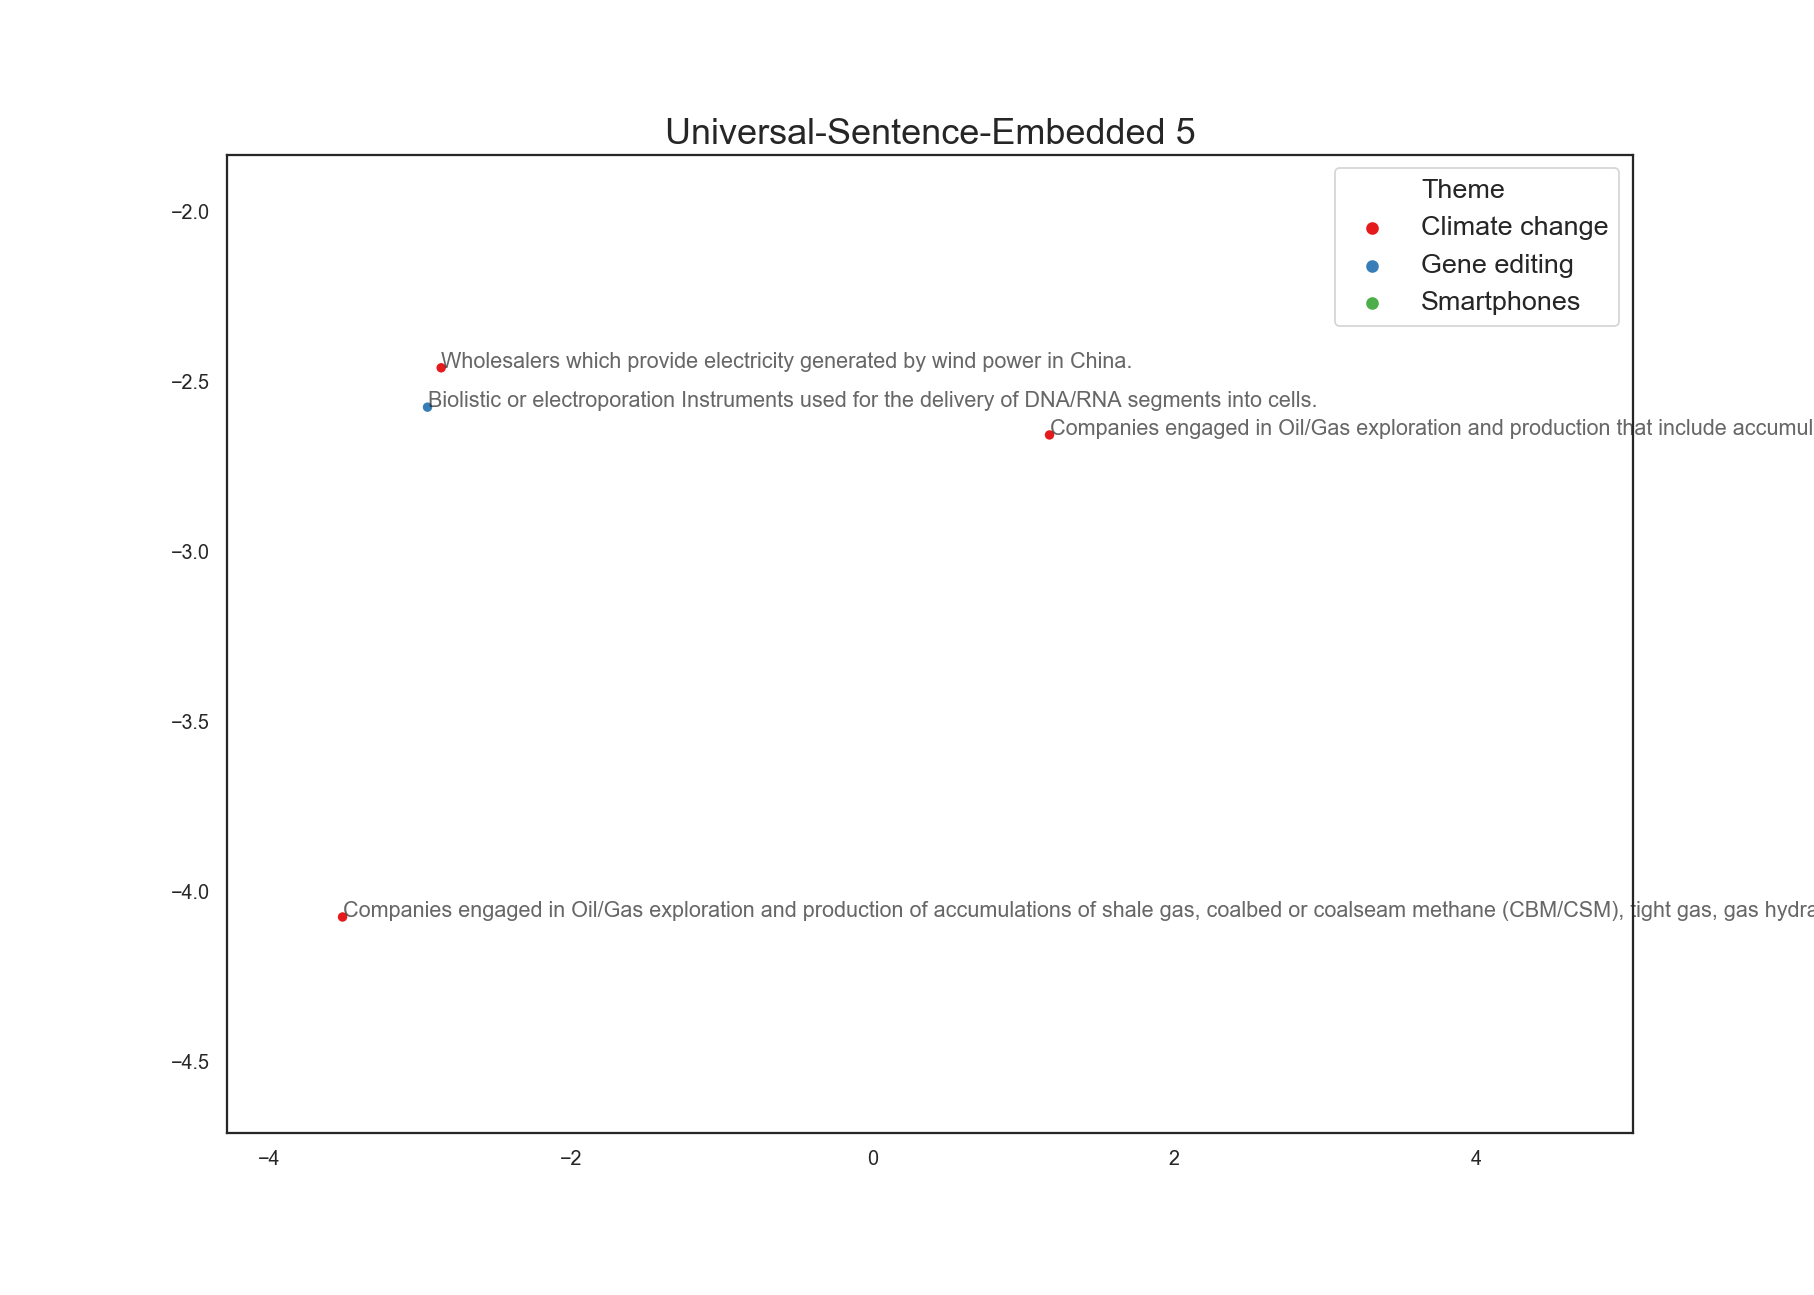

In [262]:
displayTSNE2(df.iloc[::], 'Theme',USE5_desc[::],'Universal-Sentence-Embedded 5',annot_col = 'DESCRIPTION')

<IPython.core.display.Javascript object>


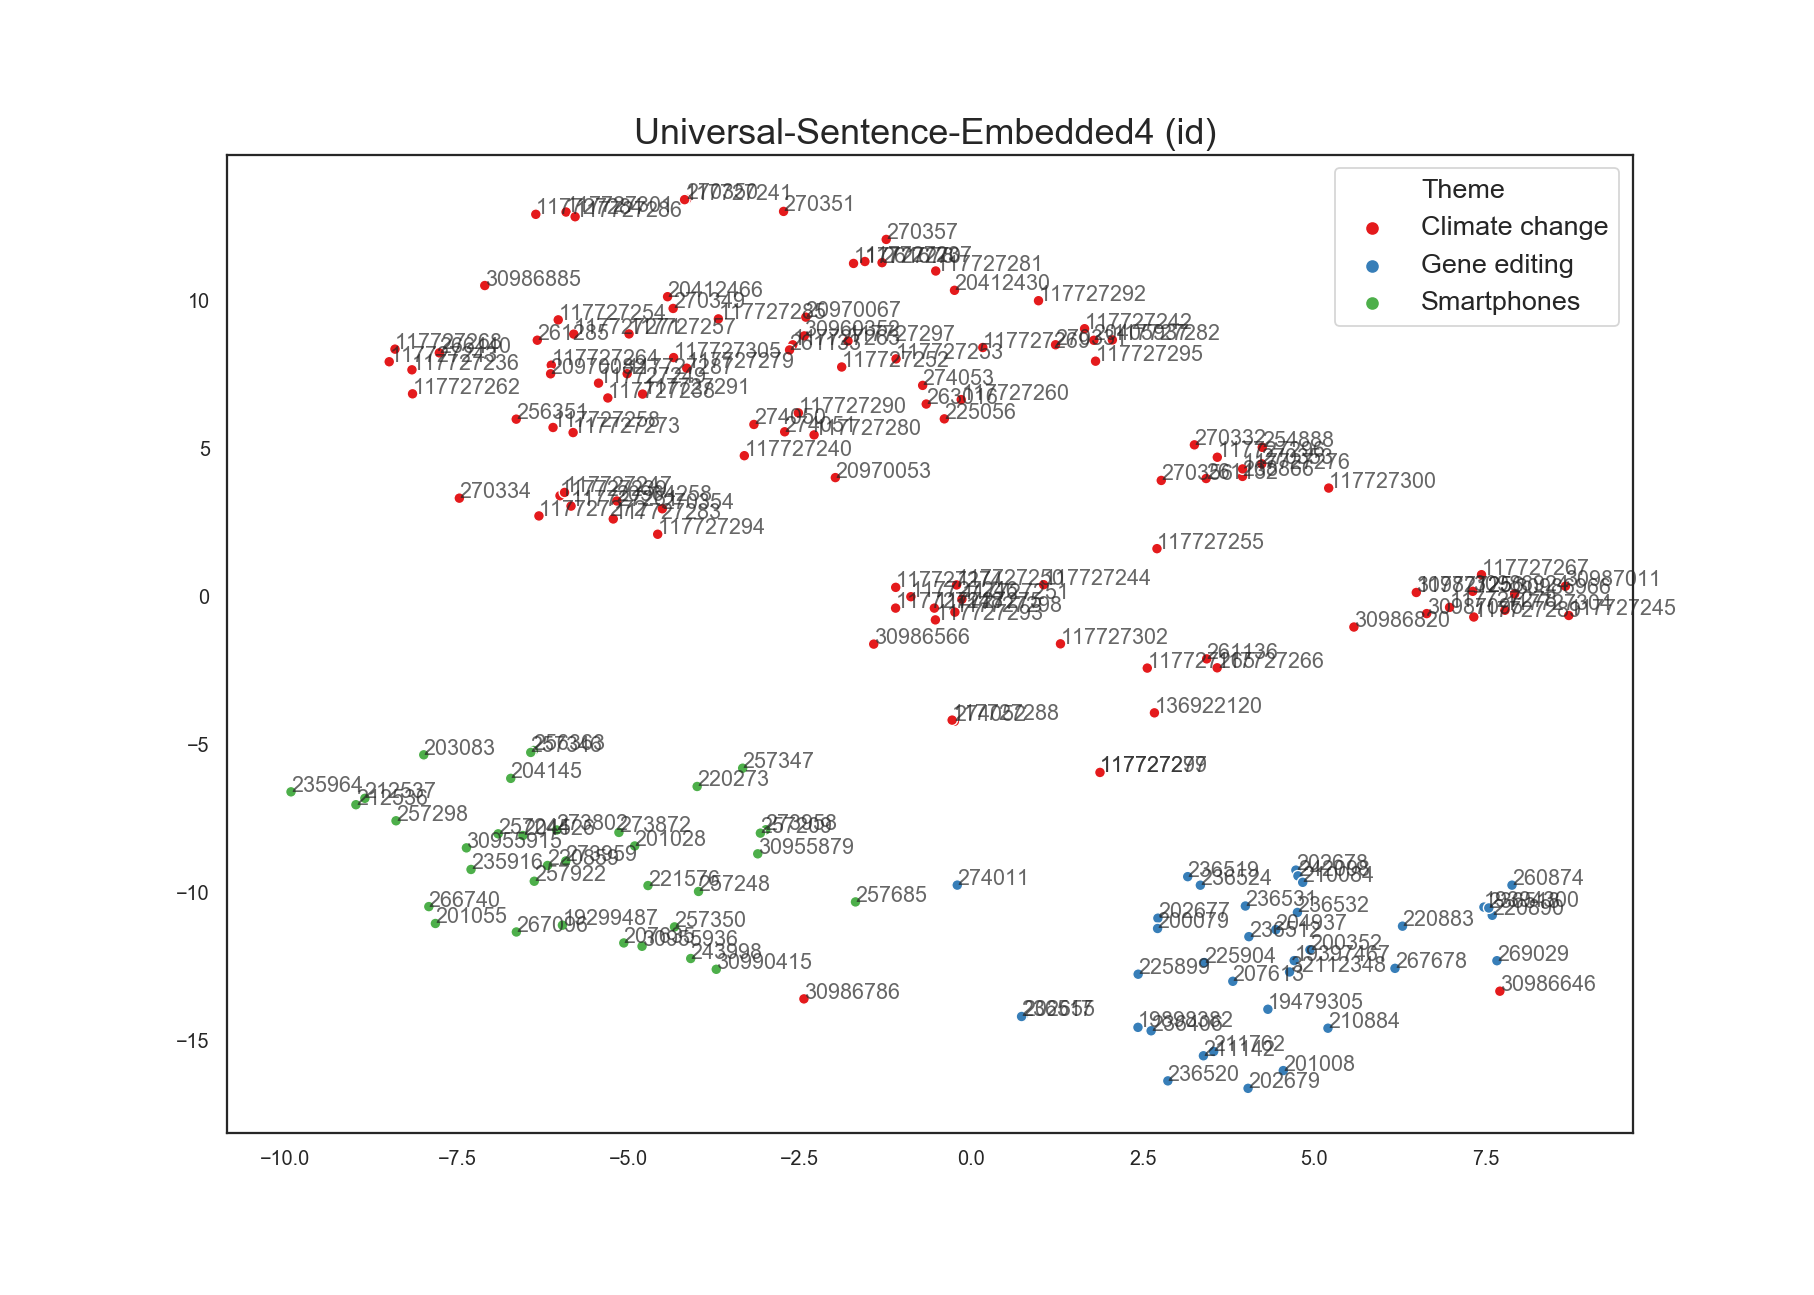

In [288]:
displayTSNE2(df.iloc[::], 'Theme',USE4_desc[::],'Universal-Sentence-Embedded4 (id) ',annot_col = 'ID')




In [287]:
outliers = df[df.ID.isin([30986786,30986646])]

# for i in range(len(outliers)):
#     print(outliers.loc[i,'NAME'],outliers.loc[i,'DESCRIPTION'])
outliers[['Theme','NAME','DESCRIPTION']]

Theme            NAME  \
89  Climate change  Unconventional   
88  Climate change  Unconventional   

                                                                                                                                                                                                                                                                                                     DESCRIPTION  
89  Companies engaged in Oil/Gas exploration and production accumulations that include shale gas, coalbed or coalseam methane (CBM/CSM), tight gas, gas hydrates and oil shale deposits in the Michigan Basin. Includes the Antrim Shale field.                                                                   
88  Companies engaged in Oil/Gas exploration and production of accumulations of shale gas, coalbed or coalseam methane (CBM/CSM), tight gas, gas hydrates and oil shale deposits in the Illinois Basin, which includes regions of Illinois, Indiana, and Northwest Kentucky. Includes the New Albany Shale Play.

### Word Embedding using Word2Vec (trained on 5.8 m patent data)
Using the pretrained Word2Vec model, we are able to find the most similar word to a given word.
+ The similarity can be represented by distance
+ To find the most similar word, the model is restricted to Unigram.i.e. One word, not phases or sentences, because we need to define a finite space for the model to search. :)
+ However, given a finite corpus compused of ducuments of a word, a phrase, sentences or even paragraphs. We are able to embed each word in a document and take the average as a vector presentation for the document. This allows us to find the the closest documents(in our case patents) in the corpus(patent space).

In [258]:
import sys
sys.path.append('../src/Patent-landscape')
from word2vec import Word2Vec
# Load the word2vec model
word2vec5_9m = Word2Vec('5.9m')
w2v_runtime = word2vec5_9m.restore_runtime()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


Will use models/5.9m directory to load/persist model information.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


INFO:tensorflow:Restoring parameters from models/5.9m/checkpoints/5.9m_abstracts.ckpt-1325000


INFO:tensorflow:Restoring parameters from models/5.9m/checkpoints/5.9m_abstracts.ckpt-1325000


In [260]:
w2v_runtime.find_similar('gene', 10)

[{'word': 'genes', 'index': 3597, 'distance': 0.17363011837005615},
 {'word': 'expression', 'index': 1675, 'distance': 0.20927608013153076},
 {'word': 'recombinant', 'index': 2917, 'distance': 0.21822530031204224},
 {'word': 'protein', 'index': 1041, 'distance': 0.23830175399780273},
 {'word': 'dna', 'index': 1754, 'distance': 0.24174463748931885},
 {'word': 'nucleic', 'index': 1483, 'distance': 0.25302237272262573},
 {'word': 'nucleotide', 'index': 3995, 'distance': 0.2568615674972534},
 {'word': 'genetic', 'index': 4000, 'distance': 0.2722873091697693},
 {'word': 'promoter', 'index': 4051, 'distance': 0.27265822887420654},
 {'word': 'polypeptide', 'index': 2842, 'distance': 0.28062689304351807}]

In [301]:
w2v_runtime.find_similar('solar', 10)

[{'word': 'photovoltaic', 'index': 4332, 'distance': 0.22832423448562622},
 {'word': 'sunlight', 'index': 8062, 'distance': 0.30681174993515015},
 {'word': 'sun', 'index': 3487, 'distance': 0.40713757276535034},
 {'word': 'energy', 'index': 308, 'distance': 0.4282582998275757},
 {'word': 'electricity', 'index': 3476, 'distance': 0.4305087924003601},
 {'word': 'concentrating', 'index': 6660, 'distance': 0.4608577489852905},
 {'word': 'pv', 'index': 10185, 'distance': 0.4629914164543152},
 {'word': 'concentrator', 'index': 6984, 'distance': 0.4696162939071655},
 {'word': 'rechargeable', 'index': 4645, 'distance': 0.47453242540359497},
 {'word': 'collector', 'index': 1519, 'distance': 0.4792707562446594}]

In [259]:
w2v_runtime.find_similar('CRISPR', 10)

KeyError: 'CRISPR'

In [ ]:
w2v_runtime.find_similar('smartphone', 10)

In [ ]:
w2v_runtime.visualize_embeddings(100)

In [ ]:
w2v_runtime.